In [1]:
# In[]
import random
import numpy as np
import matplotlib.pyplot as pl
import seaborn as sns
from astropy.constants import R_jup, R_sun, R_earth, au, M_sun
from numpy import pi
import scipy.signal as sig
import pandas as pd
rho_sun=(3*M_sun/4/np.pi/R_sun**3).value*1e-3


# In[]
def ev_amp(period, ms, rs, mbh, cosi, alpha):
    sini2=(1-cosi)*(1+cosi)
    rhos=rho_sun*ms/rs**3
    return 1.89e-2*alpha*sini2*period**(-2)/rhos/(1+ms/mbh)

def beam_amp(period, ms, mbh, cosi, alpha):
    sini=np.sqrt((1-cosi)*(1+cosi))
    return 2.8e-3*alpha*sini*period**(-1./3.)*(ms+mbh)**(-2./3.)*mbh

def sl_amp(period, ms, rs, mbh):
    return 7.15e-5*rs**(-2)*period**(2./3.)*mbh*(ms+mbh)**(1./3.)

def ev_lc(times, t0, period, ms, rs, mbh, cosi, alpha):
    phase=(times-t0)/period
    amp=ev_amp(period, ms, rs, mbh, cosi, alpha)
    return -amp*np.cos(4*pi*phase)

def beam_lc(times, t0, period, ms, mbh, cosi, alpha):
    phase=(times-t0)/period
    amp=beam_amp(period, ms, mbh, cosi, alpha)
    return amp*np.sin(2*pi*phase)

def sl_lc(times, t0, period, ms, rs, mbh, cosi):
    sma=(ms+mbh)**(1./3.)*(period/365.25)**(2./3.)
    a_rs=sma*au/rs/R_sun
    b=a_rs*cosi
    phase=np.modf(abs(times-t0)/period)[0]
    index=phase<np.sqrt(1-b**2)/pi/a_rs
    ret=np.zeros(len(times))
    amp=sl_amp(period, ms, rs, mbh)
    ret[index]=amp
    return ret

def lightcurve(times, t0, period, ms, rs, mbh, cosi, alpha_ev=1, alpha_beam=1):
    ev=ev_lc(times, t0, period, ms, rs, mbh, cosi, alpha_ev)
    beam=beam_lc(times, t0, period, ms, mbh, cosi, alpha_beam)
    sl=sl_lc(times, t0, period, ms, rs, mbh, cosi)
    return (ev, beam, sl)

def plot_dependence_p(mbhs, pmin=0.3, pmax=30):
    ps=np.logspace(-2, 2, 1000)
    ms, rs, cosi=1, 1, 0
    sns.set(style='ticks', font_scale=1.4, font='sans-serif')
    sns.set_style({'legend.frameon': True})
    pl.figure(figsize=(9,5))
    pl.xlabel('Orbital period (days)')
    pl.ylabel('Relative amplitude')
    pl.xscale('log')
    pl.yscale('log')
    pl.xlim(pmin, pmax)
    pl.ylim(5e-6, 0.5)
    for i in range(len(mbhs))[::-1]:
        mbh=mbhs[i]
        pl.plot(ps, ev_amp(ps, ms, rs, mbh, cosi, 1),
                label='EV, $M_\mathrm{BH}=%d\,M_\odot$'%mbh,
                ls='solid', color='C%d'%i)
    for i in range(len(mbhs))[::-1]:
        mbh=mbhs[i]
        pl.plot(ps, beam_amp(ps, ms, mbh, cosi, 1),
                label='Beam, $M_\mathrm{BH}=%d\,M_\odot$'%mbh,
                ls='dashed', color='C%d'%i)
    for i in range(len(mbhs))[::-1]:
        mbh=mbhs[i]
        pl.plot(ps, sl_amp(ps, ms, rs, mbh),
                label='SL, $M_\mathrm{BH}=%d\,M_\odot$'%mbh,
                ls='dotted', color='C%d'%i)
    pl.legend(loc=2, prop={'size':12},
              bbox_to_anchor=(1.02, 1))
    pl.subplots_adjust(right=0.7, top=0.95, bottom=0.15)
    #pl.savefig('./figs/signal_period.pdf', dpi=200,
    #            bbox_inches='tight', pad_inches=0.05)
    #pl.show()
    pl.close()

def plot_lc(period, mbh, cosi, flag_phase=False, exptime=29.4/1440):
    #times=np.linspace(-period, period, 1000)
    times=[0 for i in range(48*27+1)]
    times[0]=random.uniform(0,27)
    for i in range(1,48*27+1):
        times[i]=times[i-1]+1/48
    times=np.array(times)
    t0=0
    ms, rs=1, 1
    # lc model: (ev, beaming, sl)
    lc=lightcurve(times, t0, period, ms, rs, mbh, cosi,
                  alpha_ev=1, alpha_beam=1)
    labels=['EV', 'Beam', 'SL']
    # long cadence
    window_size=2*int(np.round(0.5*exptime/(times[1]-times[0])))+1
    #lcsum=pd.rolling_mean(lc[0]+lc[1]+lc[2], window_size, center=True)
    lcsum=pd.Series(lc[0]+lc[1]+lc[2]).rolling(window_size, center=True).mean() # pandas update
    # plot
    sns.set(style='ticks', font_scale=1.4, font='sans-serif')
    sns.set_style({'legend.frameon': True})
    pl.figure(figsize=(8,6))
    if flag_phase:
        pl.xlabel('Orbital phase')
        xs=times/period
        pl.xlim(-0.6, 0.6)
    else:
        pl.xlabel('Time from inferior conjunction (days)')
        xs=times
        pl.xlim(-0.6*period, 0.6*period)
    pl.ylabel('Relative flux variation')
    pl.plot(xs, lcsum, label='Total', color='k', alpha=0.8)
    shift=0#2*min(lc[0]+lc[1]+lc[2])
    for i in range(len(lc)):
        pl.plot(xs, lc[i]+shift, lw=1,
                label=labels[i],
                ls='dashed', alpha=.8)
    pl.legend(loc='best', prop={'size':12})
    pl.title('$P=%.1f\,\mathrm{d}$, $M_\mathrm{BH}=%d\,M_\odot$, $\cosi=%d$'
            %(period, mbh, cosi), fontsize=16)
    #pl.savefig('./figs/lc_p%.1f_m%.1f_cosi%.2f.pdf'%(period, mbh, cosi),
    #            dpi=200, bbox_inches='tight', pad_inches=0.05)
    pl.show()
    pl.close()
    return xs,lcsum

# In[]
%matplotlib inline
mbhs=np.logspace(0, 2, 3)
plot_dependence_p(mbhs)
#plot_lc(0.5, 10, 0.0)
#plot_lc(3, 10, 0.0, flag_phase=False)
#plot_lc(10, 10, 0.0)

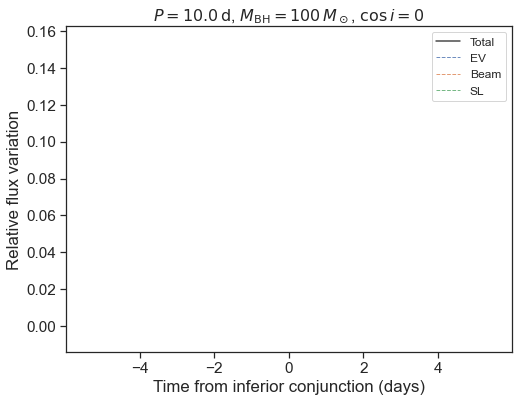

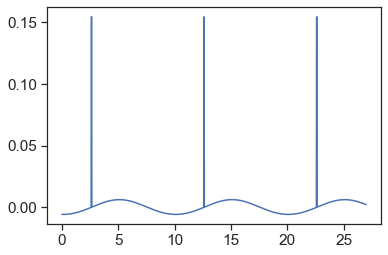

In [2]:
P=9.9930556
M=100
cosi=0
time,lcsum=plot_lc(P,M,cosi)
pl.plot(time-time[0],lcsum)

1297 1297


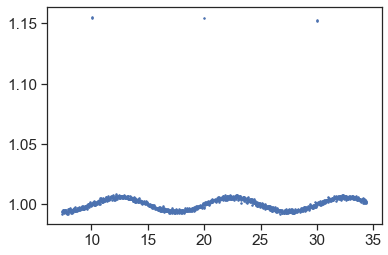

In [3]:
error=np.random.normal(0,0.001,len(time))
lcsum=lcsum+1
lcsum=lcsum+error
print(len(error),len(lcsum))
pl.plot(time,lcsum,".",markersize=3)

In [4]:
lcsum/=np.mean(lcsum)
lcsum=2-lcsum
time=time-time[0]

In [5]:
lcsum_x=[]
for i in range(len(lcsum)):
    lcsum_x.append(np.array([lcsum[i]]))
lcsum_x=np.array(lcsum_x)
time_x=[]
for i in range(len(time)):
    time_x.append(np.array([time[i]]))
time_x=np.array(time_x)
nq=1

In [6]:
!set CPLUS_INCLUDE_PATH=D:\SynologyDrive\Univ\kenkyuu\gtrap\include

In [7]:
import sys
sys.path.append('D:\\SynologyDrive\\Univ\\kenkyuu\\gtrap\\gtrap')

In [8]:
import time
import matplotlib.pyplot as plt
import math
import numpy as np
import pycuda.autoinit
import pycuda.driver as cuda
import pycuda.compiler
from pycuda.compiler import SourceModule
import geebls
import gfilter
import getstat
import read_tesslc as tes
from astropy.io import fits
import os

In [9]:
lc=lcsum_x
tu=time_x
n=len(lc)
ntrue=np.array([n])

In [10]:
##detrend (directly use)
nby=1000 ## of thread
dev_imgout=gfilter.get_detrend(lc,nby=nby,nbx=1,r=16,isw=0,osw=1) #detrend
##detrend (read from device)
offset,imgout = gfilter.get_offset(n,nq,dev_imgout,tu)
print(offset)

ydim= 1297 xdim= 1
Warning!: ydim should be divisible by nby.
elapsed_time:1.5315489768981934[sec]
[-0.00033118]


In [11]:
#gbls setting                                                                             
qmi = 0.01
qma = 0.1
#max_period = 1000.0
max_period=11.0
#min_period = 300.0
min_period=0.2
#min=(2./(float(5.0))) #### check 
fmin=(1./(float(max_period))) #### check                                                  
df = 0.00003                                                                 
nf =  int((1./min_period)/df)
nb = 1024
min_duration_hours = 0.05
max_duration_hours = 1.0
qmi = float(min_duration_hours)/24./max_period
qma = float(max_duration_hours)/24./min_period
#nf = 1024*16*2 #should be power of 2                                                     
nb = 1024
print("Pmin=",1/(fmin+nf*df),"[d] Pmax=",1/fmin,"[d]")
print(nf)

Pmin= 0.19642934311527654 [d] Pmax= 11.0 [d]
166666


In [12]:
    tu=np.array(tu,order="C").astype(np.float32)
#    imgout=np.array(imgout,order="F").astype(np.float32)
    #lc=np.copy(imgout)
    #gbls
    dev_offset = cuda.mem_alloc(offset.astype(np.float32).nbytes)
    cuda.memcpy_htod(dev_offset,offset.astype(np.float32))
    
    
    dev_ntrue = cuda.mem_alloc(ntrue.nbytes)
    cuda.memcpy_htod(dev_ntrue,ntrue)
    
    dev_tu = cuda.mem_alloc(tu.astype(np.float32).nbytes)
    cuda.memcpy_htod(dev_tu,tu.astype(np.float32))
    
    blsp=np.zeros(nf*nq).astype(np.float32)
    dev_blsp = cuda.mem_alloc(blsp.nbytes)
    
    phase1=np.zeros(nf*nq).astype(np.uint32)
    dev_phase1 = cuda.mem_alloc(phase1.nbytes) 
    phase2=np.zeros(nf*nq).astype(np.uint32)
    dev_phase2 = cuda.mem_alloc(phase2.nbytes)  
    source_module=geebls.gbls_module()
    nthread=512
    pkernel=source_module.get_function("geebls")
    
    ##compute kma,kmi,kkmi
    kma=int(qma*nb)+1
    kmi=int(qmi*nb)
    kkmi=int(n*qmi)
    sharedsize=int(4*(nb+kma)*2+4*nb)
    pkernel(dev_blsp,dev_phase1,dev_phase2,dev_imgout,dev_tu,dev_offset,dev_ntrue,\
            np.uint32(n),np.uint32(nf),np.uint32(nb),\
            np.uint32(kma),np.uint32(kmi),np.uint32(kkmi),\
            np.float32(fmin),np.float32(df),\
            block=(nthread,1,1), grid=(int(nf),int(nq)),shared=sharedsize)
    #cuda.memcpy_dtoh(blsp,dev_blsp)
    #print(blsp)

In [13]:
Pest,sde,phasebest1,phasebest2=getstat.get_blsstat(dev_blsp,dev_phase1,dev_phase2,nf,nq,df,fmin)

In [14]:
print(Pest)
print(sde)
print(phasebest1/nb)
print(nb)
pphase1=Pest*phasebest1/nb
pphase2=Pest*phasebest2/nb
print(pphase1)
print(pphase2)

[9.99109884]
[7.07122198]
[0.26074219]
1024
[2.60510097]
[2.66364256]


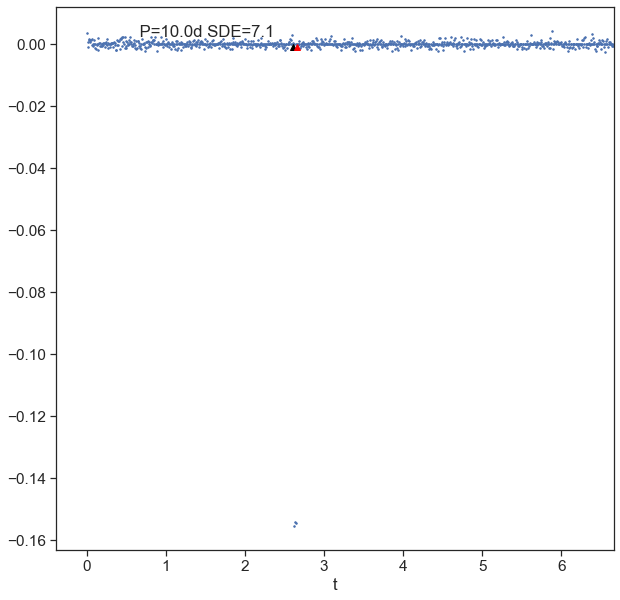

In [15]:
    #plot
    fig = plt.figure(figsize=(10,10))
    for j in range(0,np.min([nq,5])):
        ax=fig.add_subplot(np.min([nq,5]),1,j+1)
        ax.plot(np.mod(tu[:,j],Pest[j]), imgout[:,j],".",markersize=3)
        ax.plot([pphase1[j]],-0.001,"^",color="black")
        ax.plot([pphase2[j]],-0.001,"^",color="red")
        plt.xlim(pphase1[j]-3,pphase2[j]+4)
        #plt.ylim(-0.005,0.003)
        #plt.text(pphase1[j]-2,0.002,dirlist[j].replace("/sharksuck/kic/data/",""))
        plt.text(pphase1[j]-2,0.0025," P="+str(round(Pest[j],1))+"d"+" SDE="+str(round(sde[j],1)))
    plt.xlabel("t")
    #plt.savefig("keplerBLS.png")
    plt.show()

In [16]:
#load BLS spectra on device
cuda.memcpy_dtoh(blsp,dev_blsp)
print(blsp)

[0.00348187 0.00348187 0.00349795 ... 0.0017313  0.00148963 0.00149023]


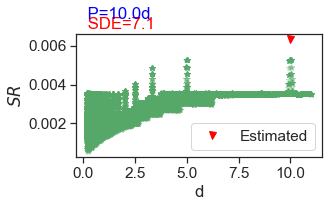

In [17]:
    freq = np.arange(fmin, df*nf+fmin, df)[0:nf]
    fig = plt.figure(figsize=(15,5))
    for j in range(0,nq):
        ax=fig.add_subplot(2,3,j+1)
        #ax.plot(Ptrue[j],0.0,"^",c="blue",markersize=7,label="Input")
        ax.plot(Pest[j],np.max(blsp[0+j*nf:nf+j*nf])*1.2,"v",c="red",markersize=7,label="Estimated")
        ax.legend()
        ax.plot(1/freq, blsp[0+j*nf:nf+j*nf], 'g*',alpha=0.3)
        plt.text(0.0,np.max(blsp[0+j*nf:nf+j*nf])*1.3," SDE="+str(round(sde[j],1)),color="red")
        plt.text(0.0,np.max(blsp[0+j*nf:nf+j*nf])*1.4," P="+str(round(Pest[j],1))+"d",color="blue")
        plt.ylabel(r"$SR$")
        #plt.title(dirlist[j].replace("/sharksuck/kic/data/",""))
        plt.xlabel("d")
        #plt.xlim(0.,10)
    plt.savefig("SLCBLS.png")
    plt.show()

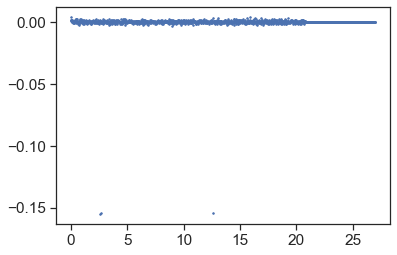

In [18]:
plt.plot(tu[:,j], imgout[:,j],".",markersize=3)

In [19]:
print(tu)

[[0.0000000e+00]
 [2.0833334e-02]
 [4.1666668e-02]
 ...
 [2.6958334e+01]
 [2.6979166e+01]
 [2.7000000e+01]]


In [20]:
print(time_x)

[[0.00000000e+00]
 [2.08333333e-02]
 [4.16666667e-02]
 ...
 [2.69583333e+01]
 [2.69791667e+01]
 [2.70000000e+01]]


In [21]:
print(lcsum_x)

[[1.00922101]
 [1.00711716]
 [1.00636189]
 ...
 [0.99905317]
 [0.99849456]
 [0.9992124 ]]


In [22]:
print(offset)

[-0.00033118]


In [23]:
print(imgout)

[[0.00361907]
 [0.00145745]
 [0.00056899]
 ...
 [0.        ]
 [0.        ]
 [0.        ]]


In [24]:
np.set_printoptions(threshold=np.inf)

In [25]:
print("# Time (BTJD),Normalized SAP_FLUX,Normalized SAP_BKG")
for i in range(len(tu)):
    print(str(tu[i][0])+","+str(1-imgout[i][0]+offset[0])+",0")

# Time (BTJD),Normalized SAP_FLUX,Normalized SAP_BKG
0.0,0.9960497411957476,0
0.020833334,0.998211363243172,0
0.041666668,0.9990998300781939,0
0.0625,0.9981437715759967,0
0.083333336,0.9984434637299273,0
0.104166664,0.9997031482926104,0
0.125,1.0000175031891558,0
0.14583333,0.9978195223084185,0
0.16666667,1.0004018339386676,0
0.1875,0.9997970852127764,0
0.20833333,0.9992240461579058,0
0.22916667,0.9992188009491656,0
0.25,1.0001405271759722,0
0.27083334,1.0008157285919879,0
0.29166666,1.0006825718155596,0
0.3125,0.9993490967026446,0
0.33333334,0.9991788658371661,0
0.35416666,0.9992029461136553,0
0.375,0.998236039566109,0
0.39583334,1.0000349077454302,0
0.41666666,0.9981119426956866,0
0.4375,0.9975516590347979,0
0.45833334,0.9972401651612017,0
0.47916666,0.9974479469528887,0
0.5,1.0010009798279498,0
0.5208333,0.9999661239853594,0
0.5416667,0.9974796566239092,0
0.5625,0.9989700111618731,0
0.5833333,0.9997013601532672,0
0.6041667,1.0008812937012408,0
0.625,1.0013505014649127,0
0.6458333,0.

In [26]:
print((pphase2-pphase1)*24)

[1.40499827]


In [27]:
print((pphase1+pphase2)/2)

[2.63437176]
